In [5]:

import scanpy as sc
import os
import gseapy as gp
import numpy as np
import matplotlib.patheffects as PathEffects
from adjustText import adjust_text
import matplotlib.pyplot as plt
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import decoupler as dc
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch


In the first step we access the read count matricies for each of the replicates and then combine them into a single annotation data object

In [6]:
def generate_combined_anndata(folder):
    """
    Each of the count matrices belonging to the different samples are accessed and combined to produce the combined annotation data object. 
   
    Parameters:
        - folder (str): Folder path containing read count matrix files from the different samples.

    Returns:
        - combined_anndata (adata): A combined Annotation Data object generated from count matrices.
    """

    anndata_list=[]
    # Iterate through the count matrix files
    for filename in os.listdir(folder):
        # Print the filename being accessed
        print(filename)
        # Access the .csv count matrices 
        if filename.endswith(".csv"):
            #Load the AnnData object
            anndata = sc.read_csv(folder + "/" + filename).T        
            
            #Append the AnnData object to the list
            anndata_list.append(anndata)

            print(f" successfully loaded {folder}/{filename}")

    # Generate the combined AnnData object
    combined_anndata = sc.concat(anndata_list)
    
    # Return the combined AnnData object
    return combined_anndata

# Call the function to generate the combined AnnData object
combined_anndata = generate_combined_anndata("../sc_lung_covid_data/count_matrices/")

GSM5226586_L06cov_raw_counts.csv
 successfully loaded ../sc_lung_covid_data/count_matrices//GSM5226586_L06cov_raw_counts.csv
GSM5226574_C51ctr_raw_counts.csv
 successfully loaded ../sc_lung_covid_data/count_matrices//GSM5226574_C51ctr_raw_counts.csv
GSM5226575_C52ctr_raw_counts.csv
 successfully loaded ../sc_lung_covid_data/count_matrices//GSM5226575_C52ctr_raw_counts.csv
GSM5226576_C53ctr_raw_counts.csv
 successfully loaded ../sc_lung_covid_data/count_matrices//GSM5226576_C53ctr_raw_counts.csv
GSM5226577_C54ctr_raw_counts.csv
 successfully loaded ../sc_lung_covid_data/count_matrices//GSM5226577_C54ctr_raw_counts.csv
GSM5226578_C55ctr_raw_counts.csv
 successfully loaded ../sc_lung_covid_data/count_matrices//GSM5226578_C55ctr_raw_counts.csv
GSM5226579_C56ctr_raw_counts.csv
 successfully loaded ../sc_lung_covid_data/count_matrices//GSM5226579_C56ctr_raw_counts.csv
GSM5226580_C57ctr_raw_counts.csv
 successfully loaded ../sc_lung_covid_data/count_matrices//GSM5226580_C57ctr_raw_counts.csv


We load the medatada file containing the cell information and use it for celltype annotation of the cells in the combined Anndata object

In [7]:
# Load the metadata file
metadata=pd.read_csv("../sc_lung_covid_data/GSE171524_lung_metaData.txt",sep="\t", index_col=0)

# Annotate the annotation data object using the information from the metadata file
combined_anndata.obs = combined_anndata.obs.merge(metadata, left_index=True, right_index=True, how='left')

/tmp/ipykernel_49636/2576408430.py:2: DtypeWarning: Columns (15,16,18,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata=pd.read_csv("../sc_lung_covid_data/GSE171524_lung_metaData.txt",sep="\t", index_col=0)


We now separate the AT2 cells for further investigation

In [8]:
cell_types= ["AT2"]

#Keep only this cell type and filter our the rest
combined_anndata=combined_anndata[combined_anndata.obs["cell_type_intermediate"].isin(cell_types)]

We check the total number of AT2 Cells in the combined Annotation data object

In [9]:
combined_anndata.obs.groupby("cell_type_intermediate").count()

,biosample_id,donor_id,species,species__ontology_label,disease,disease__ontology_label,organ,organ__ontology_label,library_preparation_protocol,library_preparation_protocol__ontology_label,...,cell_type_main,cell_type_fine,initial_clustering,age,sex,recorded_race,recorded_ethnicity,intubation_days,interval_death_symptoms_onset_days,pmi_h
cell_type_intermediate,,,,,,,,,,,,,,,,,,,,,
AT2,11341,11341,11341,11341,11341,11341,11341,11341,11341,11341,...,11341,11341,11341,11294,11341,5709,8549,4152,4376,4430


We check the total number of AT2 Cells in the combined Annotation data object coming from the SARS-CoV-2 patients and Control samples


In [10]:
combined_anndata.obs.groupby("disease__ontology_label").count()

,biosample_id,donor_id,species,species__ontology_label,disease,organ,organ__ontology_label,library_preparation_protocol,library_preparation_protocol__ontology_label,group,...,cell_type_intermediate,cell_type_fine,initial_clustering,age,sex,recorded_race,recorded_ethnicity,intubation_days,interval_death_symptoms_onset_days,pmi_h
disease__ontology_label,,,,,,,,,,,,,,,,,,,,,
COVID-19,4430,4430,4430,4430,4430,4430,4430,4430,4430,4430,...,4430,4430,4430,4383,4430,151,3532,4152,4376,4430
normal,6911,6911,6911,6911,6911,6911,6911,6911,6911,6911,...,6911,6911,6911,6911,6911,5558,5017,0,0,0


Next, we carry out differential expression analysis through pseudobulking and visualize the results


In [11]:
# The genes of interst we want to investigate
antiviral_zap=["ZC3HAV1"]
apobecs=['AICDA', 'APOBEC1', 'APOBEC2', 'APOBEC3A', 'APOBEC3B', 'APOBEC3C', 'APOBEC3D', 'APOBEC3F', 'APOBEC3G', 'APOBEC3H', 'APOBEC4']
adars=['ADAR', 'ADARB1', 'ADARB2']
gene_list=antiviral_zap+apobecs+adars

In [12]:
# Generate the pseudo-bulk profiles
pseudobulk_data = dc.get_pseudobulk(
    combined_anndata,
    sample_col='biosample_id',
    groups_col='cell_type_intermediate',
    mode='sum',
    min_cells=100,
    min_counts=10000
)

In [13]:
# Visualize the pseudobulk replicates
pseudobulk_data.obs

,biosample_id,cell_type_intermediate,donor_id,species,species__ontology_label,disease,disease__ontology_label,organ,organ__ontology_label,library_preparation_protocol,library_preparation_protocol__ontology_label,group,cell_type_main,cell_type_fine,sex,psbulk_n_cells,psbulk_counts
C51ctr_AT2,C51ctr,AT2,C51ctr,NCBITaxon:9606,Homo sapiens,PATO:0000461,normal,UBERON:0002048,lung,EFO:0009922,10x 3' v3 sequencing,Control,Epithelial cells,AT2,female,710.0,1386562.0
C52ctr_AT2,C52ctr,AT2,C52ctr,NCBITaxon:9606,Homo sapiens,PATO:0000461,normal,UBERON:0002048,lung,EFO:0009922,10x 3' v3 sequencing,Control,Epithelial cells,AT2,female,1736.0,3412535.0
C53ctr_AT2,C53ctr,AT2,C53ctr,NCBITaxon:9606,Homo sapiens,PATO:0000461,normal,UBERON:0002048,lung,EFO:0009922,10x 3' v3 sequencing,Control,Epithelial cells,AT2,male,541.0,1219247.0
C54ctr_AT2,C54ctr,AT2,C54ctr,NCBITaxon:9606,Homo sapiens,PATO:0000461,normal,UBERON:0002048,lung,EFO:0009922,10x 3' v3 sequencing,Control,Epithelial cells,AT2,female,1145.0,1476751.0
C55ctr_AT2,C55ctr,AT2,C55ctr,NCBITaxon:9606,Homo sapiens,PATO:0000461,normal,UBERON:0002048,lung,EFO:0009922,10x 3' v3 sequencing,Control,Epithelial cells,AT2,male,1353.0,1807106.0
C57ctr_AT2,C57ctr,AT2,C57ctr,NCBITaxon:9606,Homo sapiens,PATO:0000461,normal,UBERON:0002048,lung,EFO:0009922,10x 3' v3 sequencing,Control,Epithelial cells,AT2,male,1329.0,1585472.0
L01cov_AT2,L01cov,AT2,L01cov,NCBITaxon:9606,Homo sapiens,MONDO:0100096,COVID-19,UBERON:0002048,lung,EFO:0009922,10x 3' v3 sequencing,COVID-19,Epithelial cells,AT2,male,134.0,139356.0
L03cov_AT2,L03cov,AT2,L03cov,NCBITaxon:9606,Homo sapiens,MONDO:0100096,COVID-19,UBERON:0002048,lung,EFO:0009922,10x 3' v3 sequencing,COVID-19,Epithelial cells,AT2,male,151.0,600260.0
L06cov_AT2,L06cov,AT2,L06cov,NCBITaxon:9606,Homo sapiens,MONDO:0100096,COVID-19,UBERON:0002048,lung,EFO:0009922,10x 3' v3 sequencing,COVID-19,Epithelial cells,AT2,female,419.0,610336.0
L07cov_AT2,L07cov,AT2,L07cov,NCBITaxon:9606,Homo sapiens,MONDO:0100096,COVID-19,UBERON:0002048,lung,EFO:0009922,10x 3' v3 sequencing,COVID-19,Epithelial cells,AT2,male,278.0,776671.0


In [14]:
#Number of infected and control pseudobulk replicates
pseudobulk_data.obs.groupby("disease__ontology_label").count()

,biosample_id,cell_type_intermediate,donor_id,species,species__ontology_label,disease,organ,organ__ontology_label,library_preparation_protocol,library_preparation_protocol__ontology_label,group,cell_type_main,cell_type_fine,sex,psbulk_n_cells,psbulk_counts
disease__ontology_label,,,,,,,,,,,,,,,,
COVID-19,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
normal,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6


In [15]:
# Carry out DEA using Deseq2
dds = DeseqDataSet(
    adata=pseudobulk_data,
    design_factors=['disease__ontology_label'],
)

# Generate and get the DEA analysis results
dds.deseq2()
stat_ressults = DeseqStats(dds, contrast=('disease--ontology-label', 'COVID-19', 'normal'))
stat_ressults.summary()
dea_results  = stat_ressults.results_df

/tmp/ipykernel_49636/3932974060.py:2: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.05 seconds.

Fitting dispersions...
... done in 17.79 seconds.

Fitting dispersion trend curve...
/home/prittam-goswami/anaconda3/lib/python3.12/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.55 seconds.

Fitting MAP dispersions...
... done in 24.02 seconds.

Fitting LFCs...
... done in 13.83 seconds.

Calculating cook's distance...
... done in 0.10 seconds.

Replacing 203 outlier genes.

Fitting dispersions...
... done in 0.17 seconds.

Fitting MAP dispersions...
... done in 0.22 seconds.

Fitting LFCs...
... done in 0.18 seconds.

Running Wald tests...
... done in 2.86 seconds.



Log2 fold change & Wald test p-value: disease--ontology-label COVID-19 vs normal
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.726975        0.463362  1.039386  0.445804  0.655739  0.780505
A1BG-AS1   3.410690       -0.164100  0.802213 -0.204559  0.837917  0.904536
A1CF       0.434931       -0.143322  0.891740 -0.160722  0.872313       NaN
A2M        0.520088        2.478647  2.225213  1.113892  0.265326       NaN
A2M-AS1    0.145907        1.135632  3.245383  0.349922  0.726397       NaN
...             ...             ...       ...       ...       ...       ...
ZXDC      62.881699       -0.276069  0.114283 -2.415665  0.015706  0.057220
ZYG11A     0.568686       -0.972005  1.028728 -0.944861  0.344730       NaN
ZYG11B    51.428954       -0.106791  0.189513 -0.563499  0.573095  0.717761
ZYX        3.936776       -0.314882  1.109315 -0.283852  0.776523  0.865389
ZZEF1     55.410559       -0.511880  0.132749 -3.855996  0.000115  0.001410

[29082

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


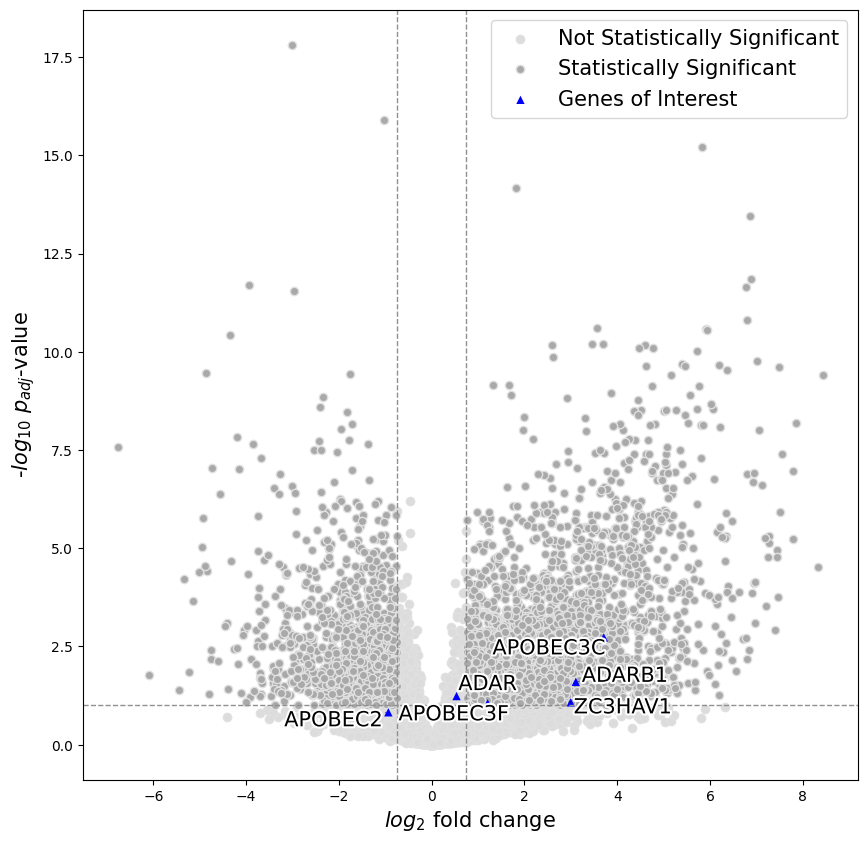

In [17]:
# Plot the DEA results volcano plots highlighting the genes of interests

def plot_volcano(data, gene_list, logfc_threshold=.75, padj_threshold=0.1, adjust=True):
    """
    Plot a volcano plot to visualize differential gene expression analysis results.

    Parameters:
        - data (pandas.DataFrame): The data containing gene expression analysis results.
        - filtered_gene_list (list): A list of genes of interest to be highlighted in the plot.
        - logfc_threshold (float, optional): The threshold for log2 fold change. Default is 0.75.
        - padj_threshold (float, optional): The threshold for adjusted p-value. Default is 0.1.
        - adjust (bool, optional): Whether to adjust the position of gene labels to avoid overlap. Default is True.

    """
    plt.figure(figsize=(10, 10))

    # Filter points based on thresholds
    nonsig_points = data[(data['padj'] > padj_threshold) | (abs(data['log2FoldChange']) < logfc_threshold)]
    sig_points = data[(data['padj'] <= padj_threshold) & (abs(data['log2FoldChange']) >= logfc_threshold)]

    # Plot non-significant points
    plt.scatter(nonsig_points['log2FoldChange'], -np.log10(nonsig_points['padj']), c='#DCDCDC', edgecolor='#E0E0E0', label='Not Statistically Significant', marker='o')

    # Plot significant points
    plt.scatter(sig_points['log2FoldChange'], -np.log10(sig_points['padj']), c='#A9A9A9', edgecolor='#E0E0E0', label='Statistically Significant', marker='o')

    # Plot genes in the filtered gene list with a different marker
    genes_of_interest = data[data.index.isin(gene_list)]
    plt.scatter(genes_of_interest['log2FoldChange'], -np.log10(genes_of_interest['padj']), c='b', edgecolor='none', label='Genes of Interest', marker='^')

    # Draw horizontal line for padj threshold
    plt.axhline(y=-np.log10(padj_threshold), color='#909090', linestyle='--', linewidth=1)

    # Draw vertical lines for log2 fold change thresholds
    plt.axvline(x=logfc_threshold, color='#909090', linestyle='--', linewidth=1)
    plt.axvline(x=-logfc_threshold, color='#909090', linestyle='--', linewidth=1)

    # Label points in the filtered gene list
    texts = []
    for gene in gene_list:
        gene_data = data[data.index == gene]
        if not gene_data.empty:
            x = gene_data['log2FoldChange'].values[0]
            y = -np.log10(gene_data['padj'].values[0])
            txt = plt.text(x, y, gene, size=15, ha='center', va='center')  
            txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
            texts.append(txt)

    plt.legend(fontsize=15)  # Increased font size of the legend
    plt.xlabel("$log_{2}$ fold change", size=15)
    plt.ylabel("-$log_{10}$ $p_{adj}$-value", size=15)

    if adjust:
        adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
    plt.show()



# Call the function to plot the volcano plot highlighting the genes of interest
plot_volcano(dea_results, gene_list)


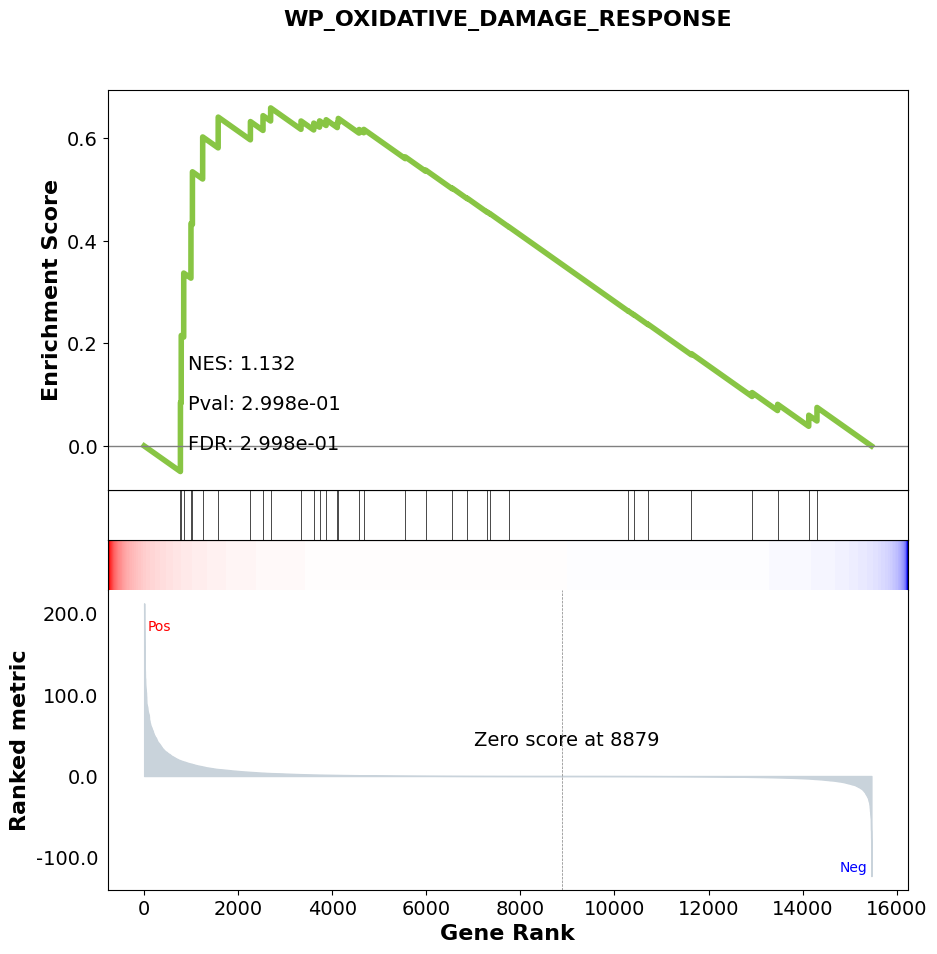

In [18]:
# Carry out Geneset Enrichment Analysis of the Oxidative damage reponse geneset

def run_gene_set_enrichment_analysis(dea_results, oxidative_stress_gene_set):
    """
    Runs gene set enrichment analysis using GSEApy for a specified gene set.

    Parameters:
        - dea_results(pandas dataframe): DESeq2 results with columns 'GeneSymbol', 'padj', and 'log2FoldChange'.
        - oxidative_stress_gene_set (str): Path to the Oxidative Damage response gene set file.
    """

    # Create a ranking of genes based on the DESeq2 results
    dea_results["-log_padj x lfc"] = -np.log(dea_results["padj"]) * dea_results["log2FoldChange"]
    # Sort the genes by the -log_padj x lfc
    ranked_genes = dea_results[['GeneSymbol', '-log_padj x lfc']].dropna().sort_values('-log_padj x lfc', ascending=False)
    # Reset the index to GeneSymbol column
    ranked_genes.reset_index(drop=True, inplace=True)

    # Run Gene Set Enrichment Analysis
    pre_res = gp.prerank(rnk=ranked_genes, gene_sets=oxidative_stress_gene_set, seed=6, min_size=0, max_size=200)

    # Plot the results
    pre_res.plot(terms="WP_OXIDATIVE_DAMAGE_RESPONSE", figsize=(10, 10))
   
# Explicitly Add the GeneSymbol column to the DataFrame as it would be needed for GSEA
dea_results["GeneSymbol"]=dea_results.index

# Call the function to run gene set enrichment analysis
run_gene_set_enrichment_analysis(dea_results, "../WP_OXIDATIVE_DAMAGE_RESPONSE.v2024.1.Hs.gmt")

/tmp/ipykernel_49636/2255600995.py:47: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


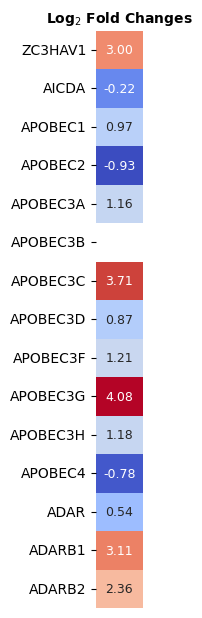

In [19]:
# Plot the log fold changes heatmap for the genes of interest

def plot_lfd_heatmap(dea_results, gene_list):
    """
    Plot the Log2 Fold Changes heatmap for the Genes of Interest
    
    Parameters:
        - dea_results(pandas dataframe): DESeq2 results with columns 'GeneSymbol', 'padj', and 'log2FoldChange'.
        - gene_list (list): List of the Gene Symbols of the genes of interest.
    """
    # Extract the Log2 Fold Changes for the genes of interest
    log2_fold_changes = [
        dea_results.loc[dea_results["GeneSymbol"] == gene, "log2FoldChange"].values[0]
        if not dea_results.loc[dea_results["GeneSymbol"] == gene, "log2FoldChange"].empty
        else None
        for gene in gene_list
    ]

    # Create a DataFrame for the log2 fold changes, keeping missing values (None)
    log2_fold_changes_df = pd.DataFrame(
        data=log2_fold_changes, 
        index=gene_list, 
        columns=["log2FoldChange"]
    )

    # Plotting the heatmap, including missing values as NaN (None will appear as NaN)
    plt.figure(figsize=(0.6, len(log2_fold_changes_df) * 0.5))  # Dynamically adjust height
    heatmap = sns.heatmap(
        log2_fold_changes_df,
        cmap="coolwarm",
        annot=True,
        fmt=".2f",
        cbar=False,
        annot_kws={"size": 9},
        mask=log2_fold_changes_df.isnull()  # Mask the missing values for better visualization
    )

    # Set the title
    plt.title(r'Log$_2$ Fold Changes', fontweight="bold", fontsize=10)

    # Turn off x-axis ticks
    plt.xticks([])

    # Set the font size for y-axis ticks
    heatmap.yaxis.set_tick_params(labelsize=10)

    plt.tight_layout()
    plt.show()


plot_lfd_heatmap(dea_results, gene_list)

/tmp/ipykernel_49636/1814070368.py:48: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


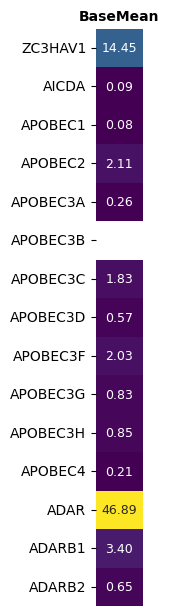

In [20]:
# Plot the Base Mean heatmap for the genes of interest

def plot_lfd_heatmap(dea_results, gene_list):
    """
    Plot the Base Mean heatmap for the Genes of Interest
    
    Parameters:
        - dea_results(pandas dataframe): DESeq2 results with columns 'GeneSymbol', 'padj', and 'log2FoldChange'.
        - gene_list (list): List of the Gene Symbols of the genes of interest.
    """

    # Extract the baseMean for the genes of interest
    base_means = [
        dea_results.loc[dea_results["GeneSymbol"] == gene, "baseMean"].values[0]
        if not dea_results.loc[dea_results["GeneSymbol"] == gene, "baseMean"].empty
        else None
        for gene in gene_list
    ]

    # Create a DataFrame for baseMean values, keeping missing values (None will appear as NaN)
    base_means_df = pd.DataFrame(
        data=base_means, 
        index=gene_list, 
        columns=["baseMean"]
    )

    # Plotting the heatmap for baseMean, including missing values as NaN (None will appear as NaN)
    plt.figure(figsize=(0.6, len(base_means_df) * 0.5))  # Dynamically adjust height
    heatmap = sns.heatmap(
        base_means_df,
        cmap="viridis",
        annot=True,
        fmt=".2f",
        cbar=False,
        annot_kws={"size": 9},
        mask=base_means_df.isnull()  # Mask the missing values for better visualization
    )

    # Set the title
    plt.title('BaseMean', fontweight="bold", fontsize=10)

    # Turn off x-axis ticks
    plt.xticks([])

    # Set the font size for y-axis ticks
    heatmap.yaxis.set_tick_params(labelsize=10)

    plt.tight_layout()
    plt.show()

plot_lfd_heatmap(dea_results, gene_list)

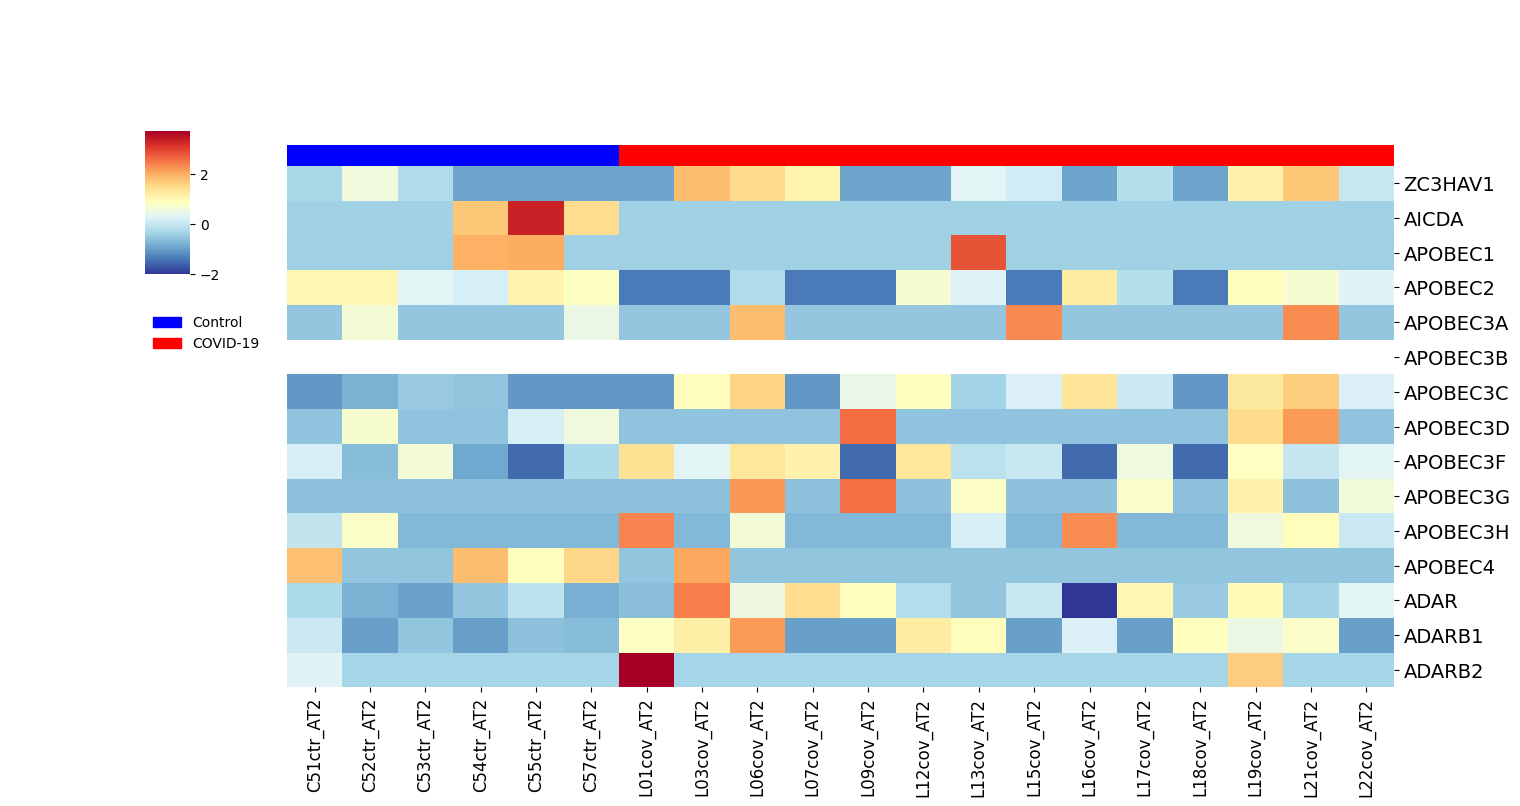

In [21]:

def plot_heatmap_with_clustermap(dds, dea_results, gene_list, metadata):
    """
    Plot a heatmap of the z-scores of the log normalized expression counts of the genes of interest for the different replicates.

    Parameters:
        - dds (object): The DESeq2 object containing normalized counts and log1p transformed data.
        - dea_results (DataFrame): The Dataframe contatining the DESeq2 results.
        - gene_list (list): The list of genes to be used in constructing the heatmap.
        - metadata (DataFrame): The DataFrame containing metadata information of the replicates.

    """
    # Extract the normalized counts and log1p transform them with a pseudocount of 1
    dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])
    # Extract the log normalized counts of the genes of interest
    dds_sigs = dds[:, dea_results[dea_results["GeneSymbol"].isin(gene_list)].index]

    # Create a DataFrame for plotting the heatmap
    grapher = pd.DataFrame(dds_sigs.layers['log1p'].T, index=dds_sigs.var_names, columns=dds_sigs.obs_names)


    # Get the indexes of control and covid conditions to order them in a preferred order
    indexes_condition_control = metadata[metadata['group'] == "Control"].index.tolist()
    indexes_condition_covid = metadata[metadata['group'] == "COVID-19"].index.tolist()
    indexes_order = indexes_condition_control + indexes_condition_covid
    
    # Clean the data and reorder it based on gene_list and indexes_order
    cleaned_data = grapher[indexes_order]
    cleaned_data = cleaned_data.reindex(gene_list)
    cleaned_data.fillna(0, inplace=True)
    cleaned_data = cleaned_data[sorted(cleaned_data.columns)]

    
    # Create a DataFrame to use as col_colors
    col_colors_df = pd.DataFrame(index=cleaned_data.columns)

    # highlight the control and the covid samples with different colors
    col_colors_df.loc[indexes_condition_control, 'color'] = 'blue'  # Color for control columns
    col_colors_df.loc[indexes_condition_covid, 'color'] = 'red'  # Color for covid columns


    # Generate heatmap with marked columns
    heatmap = sns.clustermap(cleaned_data, method='average', z_score=-1, cmap='RdYlBu_r', col_cluster=False, row_cluster=False, col_colors=[col_colors_df['color']],  figsize=(15, 8),cbar_pos=(0.1, .65, 0.03, 0.18) )
    heatmap.ax_heatmap.set_xticklabels(heatmap.ax_heatmap.get_xticklabels(), fontsize=12)
    heatmap.ax_heatmap.set_yticklabels(heatmap.ax_heatmap.get_yticklabels(), fontsize=14)
    heatmap.ax_heatmap.set_ylabel("")


    # Create the legend 
    legend = [Patch(color=color, label=label) for label, color in {'Control': 'blue', 'COVID-19': 'red'}.items()]

    # Add legend to the plot
    plt.legend(handles=legend, loc='upper left', bbox_to_anchor=(-.1, -0.2), frameon=False)

    # Show the plot
    plt.show()
    

# Generate the metadata for the samples and their associated condition
metadata = pseudobulk_data.obs[[ "group"]]

# Call the function to plot the heatmap 
plot_heatmap_with_clustermap(dds, dea_results, gene_list, metadata)


In [ ]:
# Select the columns and reset the index
# Select the columns and set 'biosample_id' as the index
# Select the columns and set 'biosample_id' as the index, without naming the index column
metadata = pseudobulk_data.obs[[ "group"]]

In [ ]:
metadata

,group
C51ctr_AT2,Control
C52ctr_AT2,Control
C53ctr_AT2,Control
C54ctr_AT2,Control
C55ctr_AT2,Control
C57ctr_AT2,Control
L01cov_AT2,COVID-19
L03cov_AT2,COVID-19
L06cov_AT2,COVID-19
L07cov_AT2,COVID-19


In [ ]:
pseudobulk_data.obs["group"]

C51ctr_AT2     Control
C52ctr_AT2     Control
C53ctr_AT2     Control
C54ctr_AT2     Control
C55ctr_AT2     Control
C57ctr_AT2     Control
L01cov_AT2    COVID-19
L03cov_AT2    COVID-19
L06cov_AT2    COVID-19
L07cov_AT2    COVID-19
L09cov_AT2    COVID-19
L12cov_AT2    COVID-19
L13cov_AT2    COVID-19
L15cov_AT2    COVID-19
L16cov_AT2    COVID-19
L17cov_AT2    COVID-19
L18cov_AT2    COVID-19
L19cov_AT2    COVID-19
L21cov_AT2    COVID-19
L22cov_AT2    COVID-19
Name: group, dtype: object